# Importing Required Libraries

In [46]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from nltk.tokenize import sent_tokenize
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

# Testing
For this section, we crawled data for 2 Indian restaurants, and we're planning to predict which aspects the restaurant is doing good and which is not qualified

### Test data

In [47]:
test = pd.read_csv('merged_restaurant.csv')
test

,id,restaurant_id,restaurant_name,sentence,id_sentence
0,1,1,Anar Indian Restaurant,everything was amazing,1
1,1,1,Anar Indian Restaurant,food and variety with custom ability ambiance with music they service and even they comfort room was excellent,2
2,1,1,Anar Indian Restaurant,we got they beef bryan and lamb marsala with plain naan,3
3,1,1,Anar Indian Restaurant,serving was generous enough for three,4
4,1,1,Anar Indian Restaurant,no gamey or domesticated taste,5
...,...,...,...,...,...
616,202,2,Gate Of India,very good,632
617,202,2,Gate Of India,cannot wait to come back,633
618,203,2,Gate Of India,amazing and delicious vegan food,634
619,204,2,Gate Of India,amazing food and amazing ambiance,636


### Preprocessing

In [48]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\DELL/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [49]:
test['review_id'] = test.index + 1
test['sentence'] = test['sentence'].apply(sent_tokenize)
test_sentences = test.explode('sentence')[['review_id', 'restaurant_id', 'sentence']].reset_index(drop=True)
test_sentences['sentence_id'] = test_sentences.index + 1
test_sentences.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621 entries, 0 to 620
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   review_id      621 non-null    int64 
 1   restaurant_id  621 non-null    int64 
 2   sentence       621 non-null    object
 3   sentence_id    621 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 19.5+ KB


In [50]:
def clean_text(txt):
    if not isinstance(txt,str):
        txt = str(txt)
    txt = txt.lower()
    txt = re.sub(r'\\[nt]*',' ',txt) #removes \n and \t tags
    txt = re.sub(r'[^A-Za-z0-9\s]',' ',txt) #removes non textual data
    if isinstance(txt, str):
        return re.sub(r'\s+', ' ', txt).strip()
    return txt
test_sentences['sentence'] = test_sentences['sentence'].apply(clean_text)
test_sentences['sentence']

0                                                                                              everything was amazing
1      food and variety with custom ability ambiance with music they service and even they comfort room was excellent
2                                                             we got they beef bryan and lamb marsala with plain naan
3                                                                               serving was generous enough for three
4                                                                                      no gamey or domesticated taste
                                                            ...                                                      
616                                                                                                         very good
617                                                                                          cannot wait to come back
618                                                     

### Aspect detection

#### Embedding

In [51]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
use_model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed_USE(input):
    return np.array(use_model(input))

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


#### Test data

In [52]:
X_test = np.array(embed_USE(test_sentences['sentence']))
print('Test input shape after USE embedding: ', X_test.shape)

Test input shape after USE embedding:  (621, 512)


#### Train data

In [53]:
aspects = ['price', 'quality', 'environment', 'service', 'other']
df = pd.read_csv('data_after_preprocessing.csv')
X1 = df['sentence']
X_train_aspects = embed_USE(X1)
print('Train input shape after USE embedding:', X_train_aspects.shape)

y_train_aspects = df[aspects].notna().astype(int)
print('Train output shape:', y_train_aspects.shape)

Train input shape after USE embedding: (5288, 512)
Train output shape: (5288, 5)


#### Model

In [54]:
clf_model = LogisticRegression(max_iter=1000, class_weight='balanced')
multi_clf_aspect = MultiOutputClassifier(clf_model)
multi_clf_aspect.fit(X_train_aspects, y_train_aspects)

MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                   max_iter=1000))

In [55]:
aspect_pred = multi_clf_aspect.predict(X_test)
aspect_pred = pd.DataFrame(aspect_pred, columns=aspects)
aspect_pred.shape, aspect_pred.head()

((621, 5),
    price  quality  environment  service  other
 0      0        0            0        0      1
 1      0        1            1        1      0
 2      0        1            0        0      0
 3      0        1            0        1      0
 4      0        1            0        0      0)

In [56]:
aspect_pred_df = pd.concat([test_sentences.reset_index(drop=True), aspect_pred.reset_index(drop=True)], axis=1)
aspect_pred_df.shape, aspect_pred_df.shape

((621, 9), (621, 9))

In [57]:
aspect_pred_df['has_aspect'] = aspect_pred_df[aspects].any(axis=1)
aspect_pred_df[['has_aspect', 'restaurant_id']].value_counts()

has_aspect  restaurant_id
True        1                499
False       1                 63
True        2                 54
False       2                  5
Name: count, dtype: int64

In [58]:
pd.set_option('display.max_colwidth', None)
aspect_pred_df[(aspect_pred_df['has_aspect'] == False) & (aspect_pred_df['restaurant_id'] == 1)][['sentence']]

,sentence
7,also had mango lass
10,comfort room was clean and complete with supplies no bidet
14,we had come on a visit to la
36,recommend sag panzer i think they best i have had in la
41,i can imagine it will be wonderful fresh out of they kitchen
...,...
507,sometimes you really need a late night linda loo
545,authentic indian food
550,a nice little indian restaurant
553,almost romantic


In [59]:
aspect_pred_df[(aspect_pred_df['has_aspect'] == False) & (aspect_pred_df['restaurant_id'] == 2)][['sentence']]

,sentence
563,note that most of they one reviews are from weird indian names so they might be competition posting fake negative reviews
569,there is two bad restaurant
597,shame in they name of indian cuisine
603,do wish they used less plastic though
609,thank you so much


### Sentiment classification

#### Test data

Output 1: aspect_pred --> Input 2

In [60]:
test_df = []
for _, row in aspect_pred_df.iterrows():
   for aspect in aspects:
      sentiment = row[aspect]
      if sentiment:
            test_df.append({
               'restaurant': row['restaurant_id'],
               'review_id': row['review_id'],
               'sentence_id': row['sentence_id'],
               'sentence': row['sentence'],
               'aspect': aspect,
            })
test_df = pd.DataFrame(test_df)
test_df

,restaurant,review_id,sentence_id,sentence,aspect
0,1,1,1,everything was amazing,other
1,1,2,2,food and variety with custom ability ambiance with music they service and even they comfort room was excellent,quality
2,1,2,2,food and variety with custom ability ambiance with music they service and even they comfort room was excellent,environment
3,1,2,2,food and variety with custom ability ambiance with music they service and even they comfort room was excellent,service
4,1,3,3,we got they beef bryan and lamb marsala with plain naan,quality
...,...,...,...,...,...
697,2,618,618,cannot wait to come back,other
698,2,619,619,amazing and delicious vegan food,quality
699,2,620,620,amazing food and amazing ambiance,quality
700,2,620,620,amazing food and amazing ambiance,environment


In [61]:
test_df['sentence'] = test_df['sentence']  + ' [ASP] ' + test_df['aspect']

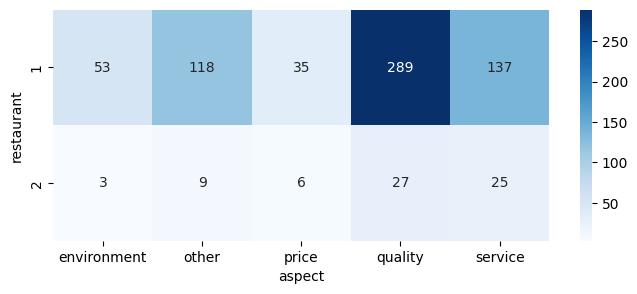

In [62]:
plt.subplots(figsize=(8, 3))
df_2dhist = pd.DataFrame({x_label: grp['aspect'].value_counts() for x_label, grp in test_df.groupby('restaurant')})
sns.heatmap(df_2dhist.T, cmap='Blues', annot=True, fmt='.0f', cbar=True)
plt.xlabel('aspect')
_ = plt.ylabel('restaurant')

In [63]:
#USE
X_test = np.array(embed_USE(test_df['sentence'].tolist()))
print('Test input shape after vectorized by USE: ', X_test.shape)

Test input shape after vectorized by USE:  (702, 512)


#### Train data

In [64]:
records = []
for idx, row in df.iterrows():
    for aspect in aspects:
        if pd.notna(row[aspect]):
            records.append({
                'sentence': row['sentence'] + ' [ASP] ' + aspect,
                'sentiment': row[aspect]
            })
df_sentiment = pd.DataFrame(records)
X2 = df_sentiment['sentence']
X2

0                       i ordered egg soft noodles from here they did not even included spoon or sport for they item how i have to eat noodles and also full of oily [ASP] quality
1                       i ordered egg soft noodles from here they did not even included spoon or sport for they item how i have to eat noodles and also full of oily [ASP] service
2                                                                          ice cream was good but it is totally got melt as delivery boy took a lot of time to reach [ASP] quality
3                                                                          ice cream was good but it is totally got melt as delivery boy took a lot of time to reach [ASP] service
4                                                                                                            he mentioned it as delivered as soon as he picked order [ASP] service
                                                                                           ...           

In [65]:
df_sentiment['sentiment'] = df_sentiment['sentiment'].str.strip()
y2 = df_sentiment['sentiment'].map({'Positive': 1, 'Negative': 0, 'Neutral': 2})

In [66]:
X_train_sentiment = embed_USE(X2)
y_train_sentiment = y2
print('Train input shape after vectorized by USE:', X_train_sentiment.shape)
print('Train output shape:', y_train_sentiment.shape)

Train input shape after vectorized by USE: (4763, 512)
Train output shape: (4763,)


#### Model

In [67]:
clf_model_sentiment = LogisticRegression(max_iter=1000, class_weight='balanced')
clf_model_sentiment.fit(X_train_sentiment, y_train_sentiment)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [68]:
y_pred = clf_model_sentiment.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['sentiment'])
y_pred['sentiment'] = y_pred['sentiment'].map({1: 'Positive', 0: 'Negative', 2: 'Neutral'})

In [69]:
sentiment_pred = pd.concat([test_df[['restaurant', 'sentence_id', 'sentence', 'aspect']], y_pred], axis=1)
sentiment_pred.head()

,restaurant,sentence_id,sentence,aspect,sentiment
0,1,1,everything was amazing [ASP] other,other,Positive
1,1,2,food and variety with custom ability ambiance with music they service and even they comfort room was excellent [ASP] quality,quality,Positive
2,1,2,food and variety with custom ability ambiance with music they service and even they comfort room was excellent [ASP] environment,environment,Positive
3,1,2,food and variety with custom ability ambiance with music they service and even they comfort room was excellent [ASP] service,service,Positive
4,1,3,we got they beef bryan and lamb marsala with plain naan [ASP] quality,quality,Neutral


In [70]:
sentiment_pred[['restaurant', 'sentiment']].value_counts()

restaurant  sentiment
1           Positive     334
            Negative     219
            Neutral       79
2           Negative      44
            Positive      24
            Neutral        2
Name: count, dtype: int64

## Final Output

In [71]:
def visualization(df, name, ax):
    sentiment_counts = df.groupby(['aspect', 'sentiment']).size().reset_index(name='count')
    pivot_df = sentiment_counts.pivot(index='aspect', columns='sentiment', values='count').fillna(0).astype(int)

    sentiments = ['Negative', 'Neutral', 'Positive']
    colors = ['#FF9999', '#CCCCCC', '#99FF99']

    pivot_df = pivot_df.reindex(aspects)
    pivot_df = pivot_df[sentiments]
    pivot_df.plot(kind='bar', color=colors, ax=ax)

    ax.set_title(name)
    ax.set_xlabel("Aspect")
    ax.set_ylabel("Count")
    ax.legend(sentiments, title="Sentiment")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

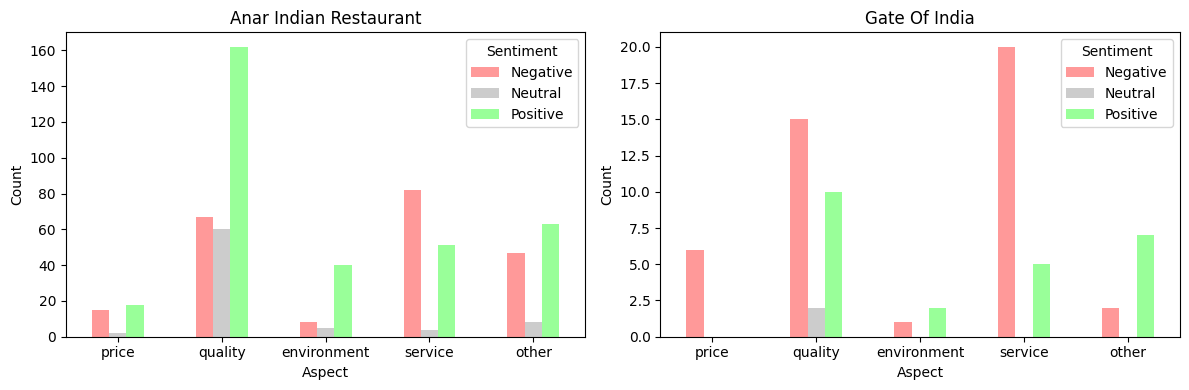

In [72]:
Anar = sentiment_pred[sentiment_pred['restaurant'] == 1]
Gate = sentiment_pred[sentiment_pred['restaurant'] == 2]

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
visualization(Anar, "Anar Indian Restaurant", axs[0])
visualization(Gate, "Gate Of India", axs[1])

plt.tight_layout()
plt.show()

In [73]:
def output(df):
   sentiment_counts = df.groupby(['aspect', 'sentiment']).size().reset_index(name='count')
   pivot_df = sentiment_counts.pivot(index='aspect', columns='sentiment', values='count').fillna(0).astype(int)
   pivot_df.columns.name = None

   def label_ratio(r):
      if r < 1:
         return 'Negative'
      elif r < 1.5:
         return 'Neutral'
      else:
         return 'Positive'

   pivot_df['ratio'] = pivot_df['Positive'] / pivot_df['Negative'].replace(0, 1e-6)
   pivot_df['label'] = pivot_df['ratio'].apply(label_ratio)
   result_df = pivot_df.reset_index()

   if aspects is not None:
        result_df['aspect'] = pd.Categorical(result_df['aspect'], categories=aspects, ordered=True)
        result_df = result_df.sort_values('aspect')
   return result_df[['aspect', 'label']].reset_index(drop=True)

In [74]:
Anar_aspect = output(Anar)
Anar_aspect

,aspect,label
0,price,Neutral
1,quality,Positive
2,environment,Positive
3,service,Negative
4,other,Neutral


In [75]:
Gate_aspect = output(Gate)
Gate_aspect

,aspect,label
0,price,Negative
1,quality,Negative
2,environment,Positive
3,service,Negative
4,other,Positive
